In [1]:
import boto3
import pandas as pd
import io
import re
import time

In [2]:
client = boto3.client('athena')

In [3]:
response = client.start_query_execution(
    QueryString="select * from \"ab23-db\".\"dws_user_behavior\"",
    QueryExecutionContext={
        'Database': "ab23-db"
    },
    ResultConfiguration={
        'OutputLocation': 's3://ab23-athena-output'
    }
)

In [4]:
raw = pd.read_csv("s3://ab23-athena-output/006b6b26-c440-48df-8087-77c7db195f7a.csv") #read data from S3
raw.head(10)

,user_id,m_p_model,m_p_brand,s_w_h,n_w,t_o_a,t_o_q,t_p_a,t_p_q,t_p_c
0,73,sumsung-16,Sumsung,640*1136,WIFI,7924.0,20,9585.0,20,NaN
1,73,sumsung-16,Sumsung,640*1136,WIFI,7924.0,20,9585.0,20,NaN
2,73,sumsung-16,Sumsung,640*1136,WIFI,7924.0,20,9585.0,20,NaN
3,73,sumsung-16,Sumsung,640*1136,WIFI,7924.0,20,9585.0,20,NaN
4,138,sumsung-8,Sumsung,640*1136,3G,4350.0,8,6040.0,8,NaN
5,138,Huawei-12,Huawei,1080*1920,3G,4350.0,8,6040.0,8,NaN
6,138,sumsung-8,Sumsung,640*1136,3G,4350.0,8,6040.0,8,NaN
7,138,Huawei-12,Huawei,1080*1920,3G,4350.0,8,6040.0,8,NaN
8,138,sumsung-8,Sumsung,640*1136,3G,4350.0,8,6040.0,8,NaN
9,138,Huawei-12,Huawei,1080*1920,3G,4350.0,8,6040.0,8,NaN


In [5]:
#screen_width_height as s_w_h,
#network_mode as n_w,
#total_order_amount as t_o_a,
#total_order_qty as t_o_q,
#total_payment_amount as t_p_a,
#total_payment_qty as t_p_q,
#total_praise_count as t_p_c

In [6]:
from sklearn.impute import SimpleImputer
import numpy as np
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [7]:
raw_tmp = imputer.fit_transform(raw)
col = ['user_id','m_p_model','m_p_brand','s_w_h','n_w','t_o_a','t_o_q','t_p_a','t_p_q','t_p_c']
raw_1 = pd.DataFrame(data=raw_tmp, columns=col)

raw_1.head(10)

,user_id,m_p_model,m_p_brand,s_w_h,n_w,t_o_a,t_o_q,t_p_a,t_p_q,t_p_c
0,73,sumsung-16,Sumsung,640*1136,WIFI,7924,20,9585,20,1384
1,73,sumsung-16,Sumsung,640*1136,WIFI,7924,20,9585,20,1384
2,73,sumsung-16,Sumsung,640*1136,WIFI,7924,20,9585,20,1384
3,73,sumsung-16,Sumsung,640*1136,WIFI,7924,20,9585,20,1384
4,138,sumsung-8,Sumsung,640*1136,3G,4350,8,6040,8,1384
5,138,Huawei-12,Huawei,1080*1920,3G,4350,8,6040,8,1384
6,138,sumsung-8,Sumsung,640*1136,3G,4350,8,6040,8,1384
7,138,Huawei-12,Huawei,1080*1920,3G,4350,8,6040,8,1384
8,138,sumsung-8,Sumsung,640*1136,3G,4350,8,6040,8,1384
9,138,Huawei-12,Huawei,1080*1920,3G,4350,8,6040,8,1384


<AxesSubplot:>

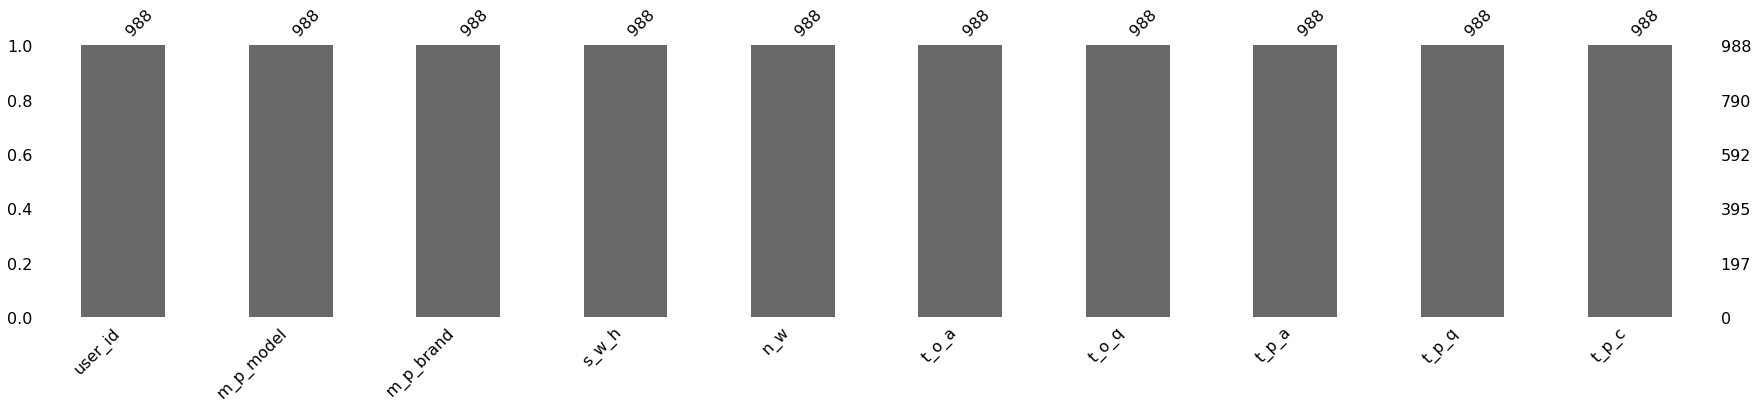

In [10]:
import missingno
missingno.bar(raw_1,sort='ascending',figsize=(30,5))

In [11]:
from sklearn.preprocessing import LabelEncoder
encoder_x=LabelEncoder()
x = encoder_x.fit_transform(raw_1['m_p_model'])
y = encoder_x.fit_transform(raw_1['m_p_brand'])
z = encoder_x.fit_transform(raw_1['s_w_h'])
a = encoder_x.fit_transform(raw_1['n_w'])

In [12]:
raw_2 = pd.DataFrame()

In [13]:
raw_2['user_id'] = raw_1['user_id']
raw_2['m_p_model'] = x
raw_2['m_p_brand'] = y
raw_2['s_w_h'] = z
raw_2['n_w'] = a
raw_2['t_o_a'] = raw_1['t_o_a']
raw_2['t_o_q'] = raw_1['t_o_q']
raw_2['t_p_a'] = raw_1['t_p_a']
raw_2['t_p_q'] = raw_1['t_p_q']
raw_2['t_p_c'] = raw_1['t_p_c']

In [14]:
raw_2.head(10)

,user_id,m_p_model,m_p_brand,s_w_h,n_w,t_o_a,t_o_q,t_p_a,t_p_q,t_p_c
0,73,47,2,1,2,7924,20,9585,20,1384
1,73,47,2,1,2,7924,20,9585,20,1384
2,73,47,2,1,2,7924,20,9585,20,1384
3,73,47,2,1,2,7924,20,9585,20,1384
4,138,56,2,1,0,4350,8,6040,8,1384
5,138,23,1,0,0,4350,8,6040,8,1384
6,138,56,2,1,0,4350,8,6040,8,1384
7,138,23,1,0,0,4350,8,6040,8,1384
8,138,56,2,1,0,4350,8,6040,8,1384
9,138,23,1,0,0,4350,8,6040,8,1384


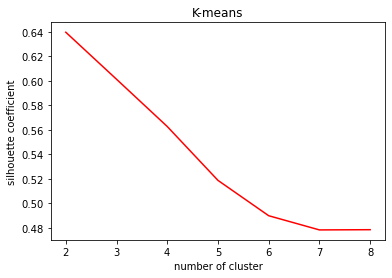

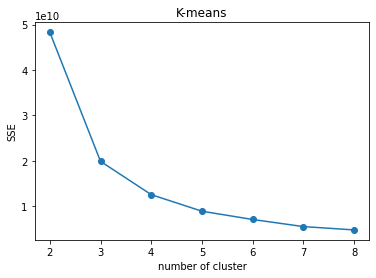

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import metrics

silhouette_score = []
sse = []
k = []
for i in range(2,9):
    est = KMeans(n_clusters=i).fit(raw_2)
    r = est.labels_
    s1 = metrics.silhouette_score(raw_2, r, metric = 'euclidean')
    silhouette_score.append(s1)
    s2 = est.inertia_
    sse.append(s2)
    k.append(i)
    r = []
    s1 = []
    #print(u'K=%s, Silhouette=%.03f, SSE=%.03f' %(k,s1,s2))

#generate silhouette
plt.figure()
plt.title('K-means')
plt.plot(k, silhouette_score , 'r')
plt.xlabel('number of cluster')
plt.ylabel('silhouette coefficient')

#generate SSE
plt.figure()
plt.title('K-means')
plt.plot(k, sse, 'o-')
plt.xlabel('number of cluster')
plt.ylabel('SSE')
plt.show()

Text(0, 0.5, 'silhouette coefficient')

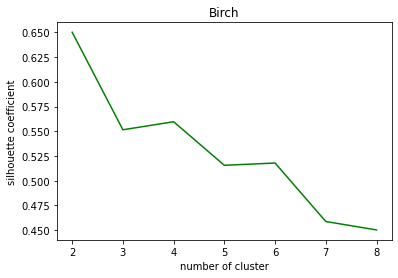

In [16]:
from sklearn.cluster import Birch
silhouette_score_1 = []
k_1 = []
for i in range(2,9):
    est = Birch(n_clusters=i).fit(raw_2)
    r = est.labels_
    s1 = metrics.silhouette_score(raw_2, r, metric = 'euclidean')
    silhouette_score_1.append(s1)
    k_1.append(i)
    r = []
    s1 = []

#generate silhouette
plt.figure()
plt.title('Birch')
plt.plot(k_1, silhouette_score_1 , 'g')
plt.xlabel('number of cluster')
plt.ylabel('silhouette coefficient')

In [ ]:
from sklearn.cluster import SpectralClustering

est = SpectralClustering(n_clusters=2).fit(raw_1)
r_tmp = est.labels_
s_tmp = metrics.silhouette_score(raw_1, r_tmp, metric = 'euclidean')
print(s_tmp)

silhouette_score_2 = []
k_2 = []
for i in range(2,9):
    est = SpectralClustering(n_clusters=i).fit(raw_1)
    r = est.labels_
    s1 = metrics.silhouette_score(raw_1, r, metric = 'euclidean')
    silhouette_score_2.append(s1)
    k_2.append(i)
    print(u'K=%s,Silhouette=%.03f' %(i,s1))
    r = []
    s1 = []    

Text(0, 0.5, 'silhouette coefficient')

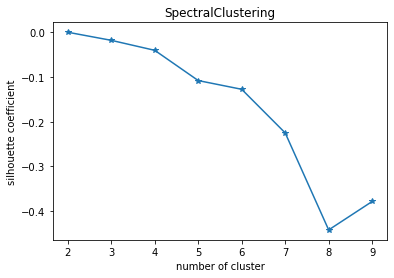

In [17]:
#generate silhouette
plt.figure()
plt.title('SpectralClustering')
plt.plot(k_2, sil_score , '*-')
plt.xlabel('number of cluster')
plt.ylabel('silhouette coefficient')

In [18]:
final_model = Birch(n_clusters=3).fit(raw_2)

In [20]:
label = final_model.predict(raw_2)
raw_2['label'] = label
raw_2

,user_id,m_p_model,m_p_brand,s_w_h,n_w,t_o_a,t_o_q,t_p_a,t_p_q,t_p_c,label
0,73,47,2,1,2,7924,20,9585,20,1384,1
1,73,47,2,1,2,7924,20,9585,20,1384,1
2,73,47,2,1,2,7924,20,9585,20,1384,1
3,73,47,2,1,2,7924,20,9585,20,1384,1
4,138,56,2,1,0,4350,8,6040,8,1384,2
...,...,...,...,...,...,...,...,...,...,...,...
983,167,45,2,2,0,14764,28,16828,28,372,1
984,167,45,2,2,0,14764,28,16828,28,372,1
985,167,45,2,2,0,14764,28,16828,28,372,1
986,167,25,1,3,2,14764,28,16828,28,372,1


In [21]:
group_label_0 = raw_2[raw_2['label'].isin([0])]

In [22]:
t_o_a_0 = pd.to_numeric(group_label_0['t_o_a'])
t_o_q_0 = pd.to_numeric(group_label_0['t_o_q'])
t_p_a_0 = pd.to_numeric(group_label_0['t_p_a'])
t_p_q_0 = pd.to_numeric(group_label_0['t_p_q'])
t_p_c_0 = pd.to_numeric(group_label_0['t_p_c'])
tmp_df_0 = pd.DataFrame()
tmp_df_0['t_o_a'] = t_o_a_0
tmp_df_0['t_o_q'] = t_o_q_0
tmp_df_0['t_p_a'] = t_p_a_0
tmp_df_0['t_p_q'] = t_p_q_0
tmp_df_0['t_p_c'] = t_p_c_0
tmp_df_0.describe()

,t_o_a,t_o_q,t_p_a,t_p_q,t_p_c
count,156.000000,156.000000,156.000000,156.000000,156.000000
mean,24720.679487,47.391026,25470.384615,47.391026,1991.205128
std,7491.738187,15.649208,6374.312366,15.649208,1232.459941
min,14176.000000,28.000000,17213.000000,28.000000,1172.000000
25%,18890.000000,39.000000,19622.000000,39.000000,1384.000000
50%,22470.000000,42.000000,22866.000000,42.000000,1384.000000
75%,33540.000000,65.000000,30180.000000,65.000000,1384.000000
max,36968.000000,72.000000,38052.000000,72.000000,5256.000000


In [23]:
group_label_1 = raw_2[raw_2['label'].isin([1])]

In [24]:
t_o_a_1 = pd.to_numeric(group_label_1['t_o_a'])
t_o_q_1 = pd.to_numeric(group_label_1['t_o_q'])
t_p_a_1 = pd.to_numeric(group_label_1['t_p_a'])
t_p_q_1 = pd.to_numeric(group_label_1['t_p_q'])
t_p_c_1 = pd.to_numeric(group_label_1['t_p_c'])
tmp_df = pd.DataFrame()
tmp_df['t_o_a'] = t_o_a_1
tmp_df['t_o_q'] = t_o_q_1
tmp_df['t_p_a'] = t_p_a_1
tmp_df['t_p_q'] = t_p_q_1
tmp_df['t_p_c'] = t_p_c_1
tmp_df.describe()

,t_o_a,t_o_q,t_p_a,t_p_q,t_p_c
count,359.000000,359.000000,359.000000,359.000000,359.000000
mean,10867.674095,20.122563,11326.072423,20.122563,1393.626741
std,2888.617341,6.651040,3092.537679,6.651040,461.426916
min,6158.000000,8.000000,6222.000000,8.000000,28.000000
25%,8280.000000,15.000000,8442.000000,15.000000,1384.000000
50%,11055.000000,20.000000,10744.000000,20.000000,1384.000000
75%,13588.000000,24.000000,13816.000000,24.000000,1384.000000
max,17292.000000,36.000000,17101.000000,36.000000,3492.000000


In [25]:
group_label_2 = raw_2[raw_2['label'].isin([2])]
t_o_a_2 = pd.to_numeric(group_label_2['t_o_a'])
t_o_q_2 = pd.to_numeric(group_label_2['t_o_q'])
t_p_a_2 = pd.to_numeric(group_label_2['t_p_a'])
t_p_q_2 = pd.to_numeric(group_label_2['t_p_q'])
t_p_c_2 = pd.to_numeric(group_label_2['t_p_c'])
tmp_df_2 = pd.DataFrame()
tmp_df_2['t_o_a'] = t_o_a_2
tmp_df_2['t_o_q'] = t_o_q_2
tmp_df_2['t_p_a'] = t_p_a_2
tmp_df_2['t_p_q'] = t_p_q_2
tmp_df_2['t_p_c'] = t_p_c_2
tmp_df_2.describe()

,t_o_a,t_o_q,t_p_a,t_p_q,t_p_c
count,473.000000,473.000000,473.000000,473.000000,473.000000
mean,3476.579281,7.372093,3179.621564,7.372093,1494.917548
std,1651.619671,4.065802,1822.533180,4.065802,595.176583
min,566.000000,1.000000,231.000000,1.000000,204.000000
25%,2192.000000,4.000000,1748.000000,4.000000,1384.000000
50%,3402.000000,6.000000,3246.000000,6.000000,1384.000000
75%,4590.000000,10.000000,4308.000000,10.000000,1384.000000
max,6696.000000,18.000000,8160.000000,18.000000,3956.000000


<AxesSubplot:>

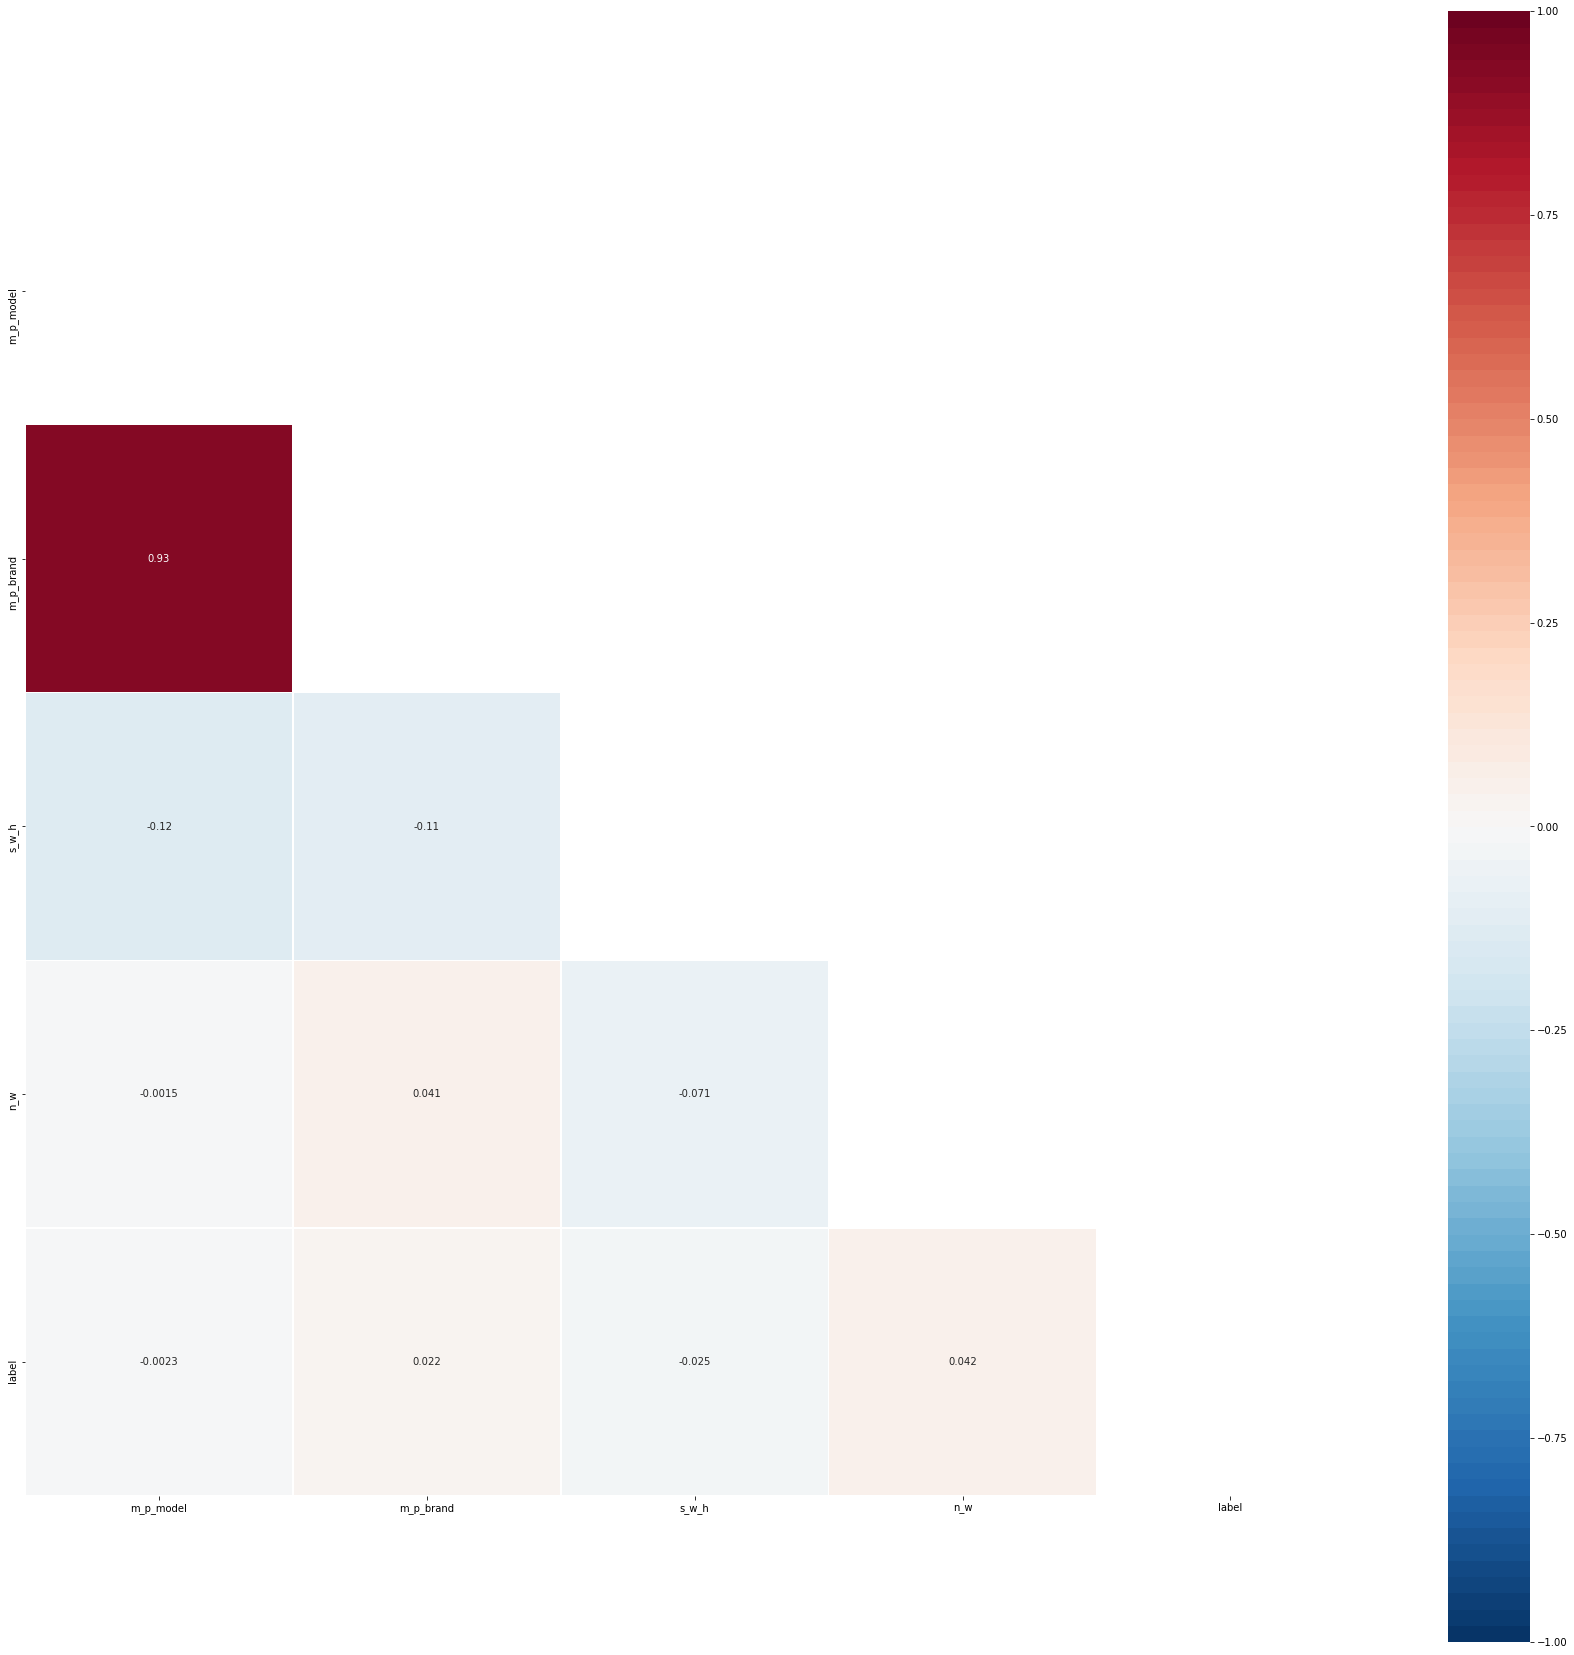

In [27]:
import seaborn as sns
mask = np.zeros_like(raw_2.corr())
mask[np.triu_indices_from(mask)] = True
fig=plt.figure(figsize=(30,30))
sns.heatmap(raw_2.corr(),vmin=-1,vmax=1,mask=mask,annot=True,square=True,cmap=sns.color_palette("RdBu_r",100),linewidth=.5)

<AxesSubplot:>

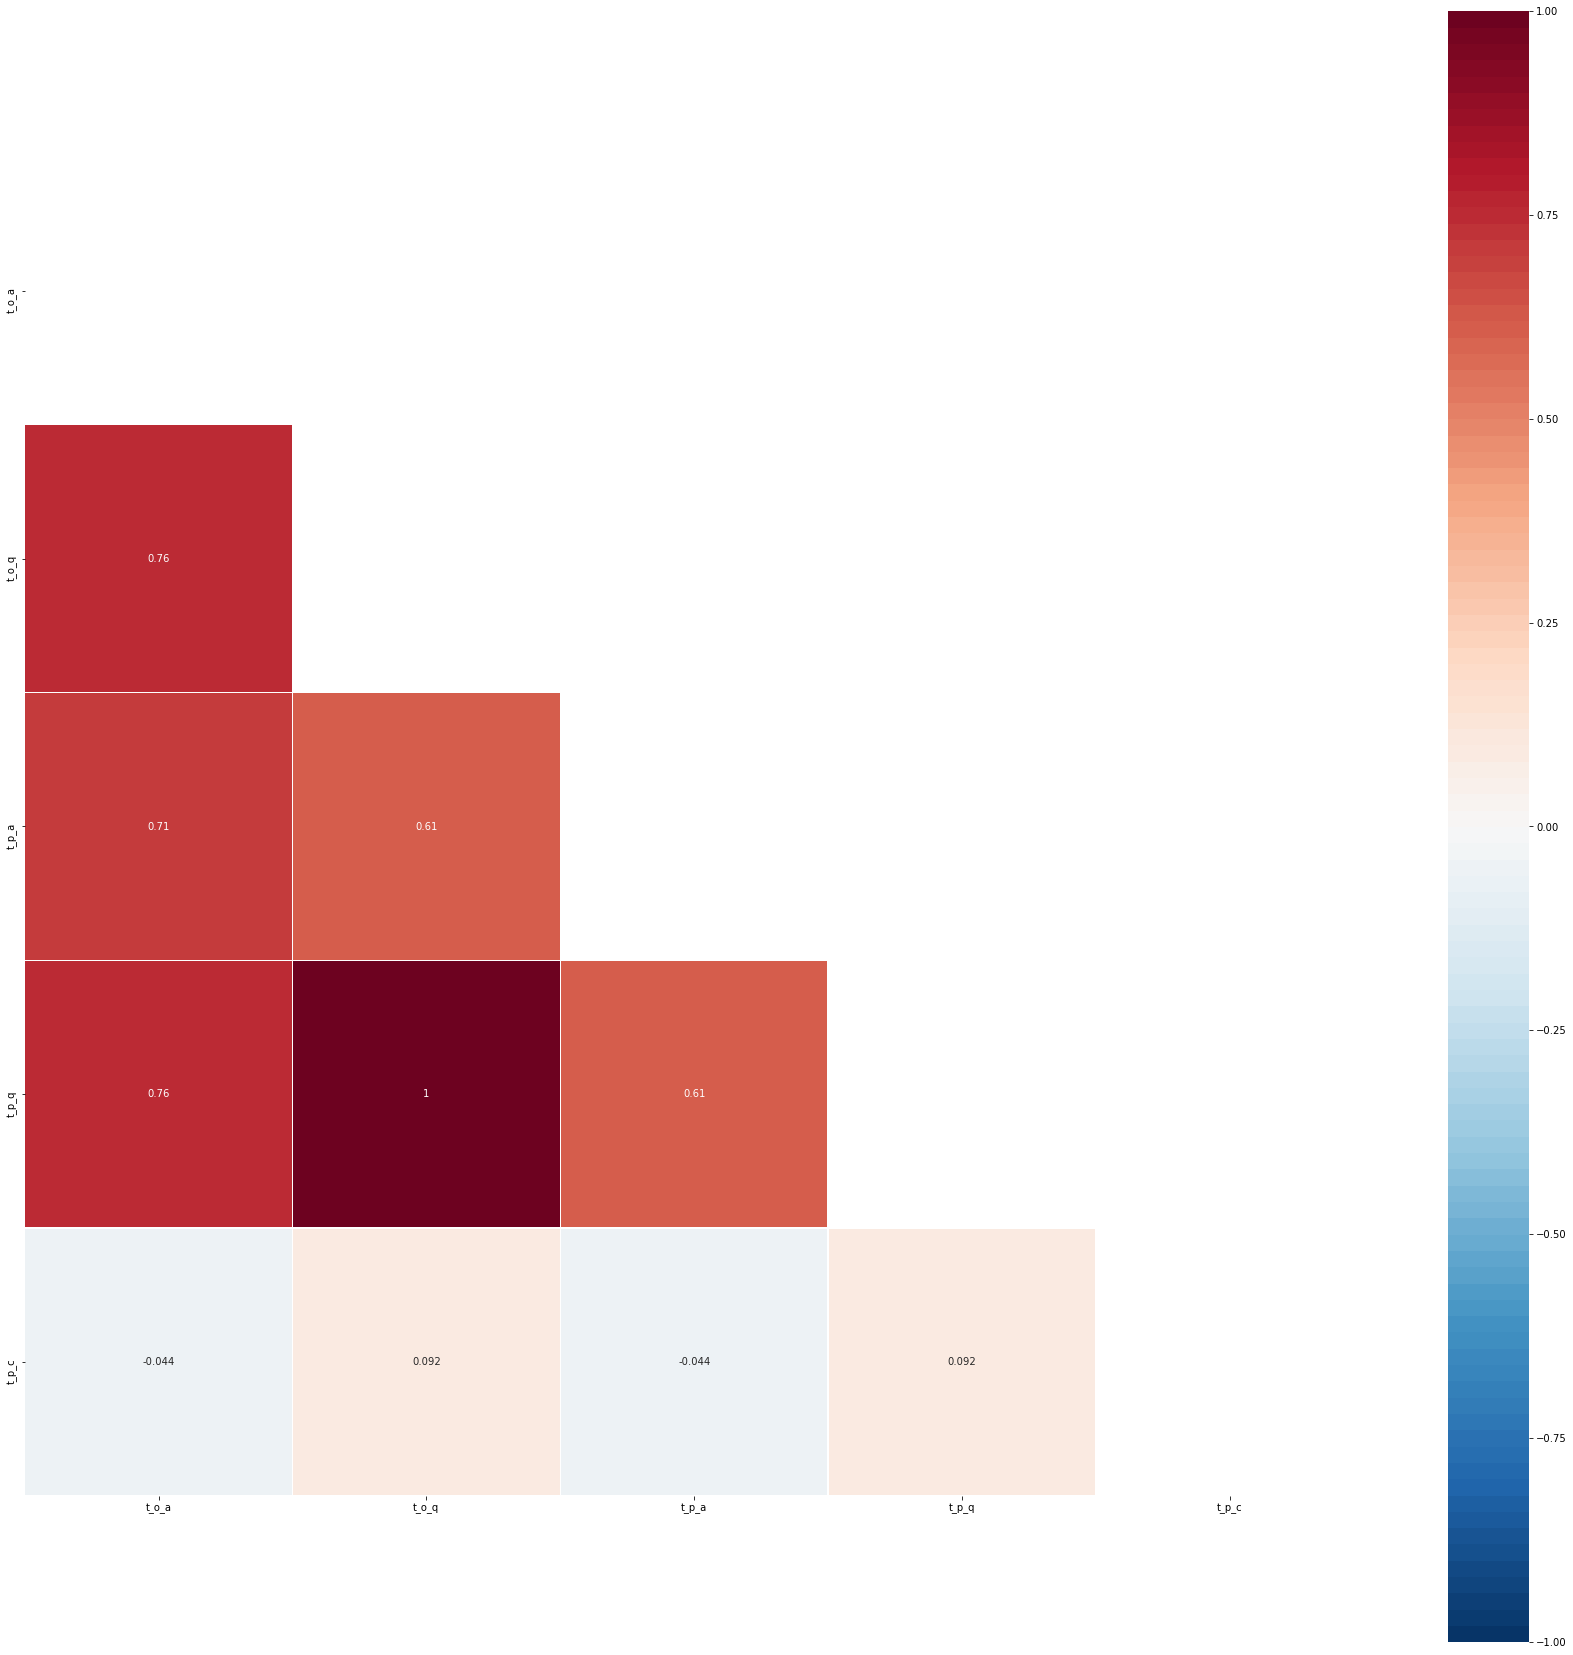

In [28]:
mask = np.zeros_like(tmp_df.corr())
mask[np.triu_indices_from(mask)] = True
fig=plt.figure(figsize=(30,30))
sns.heatmap(tmp_df.corr(),vmin=-1,vmax=1,mask=mask,annot=True,square=True,cmap=sns.color_palette("RdBu_r",100),linewidth=.5)

In [29]:
#screen_width_height as s_w_h,
#network_mode as n_w,
#total_order_amount as t_o_a,
#total_order_qty as t_o_q,
#total_payment_amount as t_p_a,
#total_payment_qty as t_p_q,
#total_praise_count as t_p_c